In [1]:
# Importing the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [3]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test

In [5]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [6]:
# Importing adasyn
from imblearn.over_sampling import ADASYN

In [7]:
# Instantiate adasyn
ada = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)

In [8]:
from collections import Counter
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_adasyn))

Before sampling class distribution:- Counter({0: 227449, 1: 396})
New class distribution:- Counter({0: 227449, 1: 227448})


In [9]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [10]:
# Creating KFold object with 3 splits
folds = KFold(n_splits=3, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as roc-auc
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_adasyn, y_train_adasyn)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [11]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.798086,0.052728,0.045983,0.000802,0.01,{'C': 0.01},0.963472,0.962327,0.963273,0.963024,0.000499,6,0.962770,0.963211,0.963172,0.963051,0.000199
1,1.206149,0.008462,0.074495,0.024473,0.1,{'C': 0.1},0.963578,0.962435,0.963370,0.963128,0.000497,5,0.962881,0.963305,0.963272,0.963153,0.000192
2,1.242601,0.038268,0.084515,0.029889,1,{'C': 1},0.963585,0.962442,0.963376,0.963134,0.000497,4,0.962890,0.963312,0.963278,0.963160,0.000191
3,1.336198,0.163093,0.061502,0.005789,10,{'C': 10},0.963585,0.962443,0.963377,0.963135,0.000496,3,0.962891,0.963312,0.963279,0.963161,0.000191
4,1.411510,0.091256,0.095684,0.019566,100,{'C': 100},0.963585,0.962443,0.963377,0.963135,0.000496,2,0.962891,0.963312,0.963279,0.963161,0.000191
5,1.308888,0.113807,0.071192,0.011189,1000,{'C': 1000},0.963585,0.962443,0.963377,0.963135,0.000496,1,0.962891,0.963312,0.963279,0.963161,0.000191


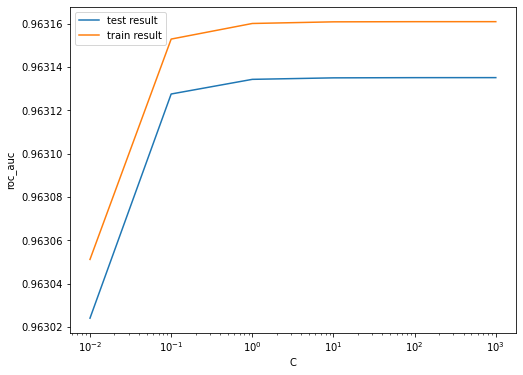

In [12]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [13]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.963135148223901 at C = 1000


In [14]:
# Instantiate the model with best C
logistic_bal_adasyn = LogisticRegression(C=1000)

In [15]:

# Fit the model on the train set
logistic_bal_adasyn_model = logistic_bal_adasyn.fit(X_train_adasyn, y_train_adasyn)

In [16]:
# Predictions on the train set
y_train_pred = logistic_bal_adasyn_model.predict(X_train_adasyn)

In [17]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_adasyn, y_train_pred)
print(confusion)

[[207019  20430]
 [ 31286 196162]]


In [18]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [19]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_adasyn, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_adasyn, y_train_pred))

Accuracy:- 0.8863127257379143
Sensitivity:- 0.862447680348915
Specificity:- 0.9101776662020936
F1-Score:- 0.8835330150436899


In [20]:
# classification_report
print(classification_report(y_train_adasyn, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89    227449
           1       0.91      0.86      0.88    227448

    accuracy                           0.89    454897
   macro avg       0.89      0.89      0.89    454897
weighted avg       0.89      0.89      0.89    454897



In [21]:
# Predicted probability
y_train_pred_proba = logistic_bal_adasyn_model.predict_proba(X_train_adasyn)[:,1]

In [22]:
# roc_auc
auc = metrics.roc_auc_score(y_train_adasyn, y_train_pred_proba)
auc

0.9631610160068507

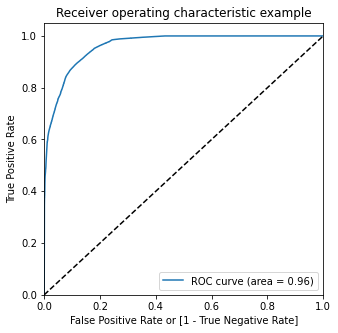

In [23]:
# Plot the ROC curve
draw_roc(y_train_adasyn, y_train_pred_proba)

In [24]:
# Prediction on the test set
y_test_pred = logistic_bal_adasyn_model.predict(X_test)

In [25]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[51642  5224]
 [    4    92]]


In [26]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [27]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9082195147642288
Sensitivity:- 0.9583333333333334
Specificity:- 0.9081349136566665


In [28]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56866
           1       0.02      0.96      0.03        96

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962



In [29]:
# Predicted probability
y_test_pred_proba = logistic_bal_adasyn_model.predict_proba(X_test)[:,1]

In [30]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9671573487086602

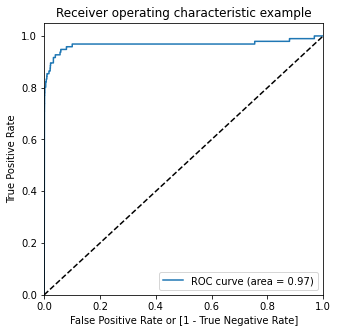

In [31]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [32]:
# Importing XGBoost
from xgboost import XGBClassifier

In [33]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_adasyn, y_train_adasyn)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...one,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                 

In [34]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,29.194595,4.555529,0.179882,0.015184,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.975756,0.996202,0.994729,0.988896,0.009310,5,0.999304,0.999014,0.999315,0.999211,0.000139
1,41.462593,0.462332,0.178233,0.003937,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.978500,0.996075,0.993204,0.989260,0.007698,3,0.999295,0.999072,0.999224,0.999197,0.000093
2,51.844169,1.239640,0.176414,0.000958,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.977110,0.996104,0.993729,0.988981,0.008450,4,0.999300,0.999069,0.999194,0.999188,0.000095
3,31.254090,0.610798,0.188795,0.017841,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.979173,0.998146,0.998145,0.991822,0.008944,1,0.999937,0.999934,0.999942,0.999938,0.000004
4,46.849753,4.457119,0.204930,0.024164,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.971621,0.996825,0.997548,0.988664,0.012055,6,0.999950,0.999942,0.999947,0.999946,0.000003
5,53.219430,0.405185,0.214799,0.011124,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.977355,0.998183,0.995571,0.990370,0.009265,2,0.999953,0.999935,0.999955,0.999948,0.000009


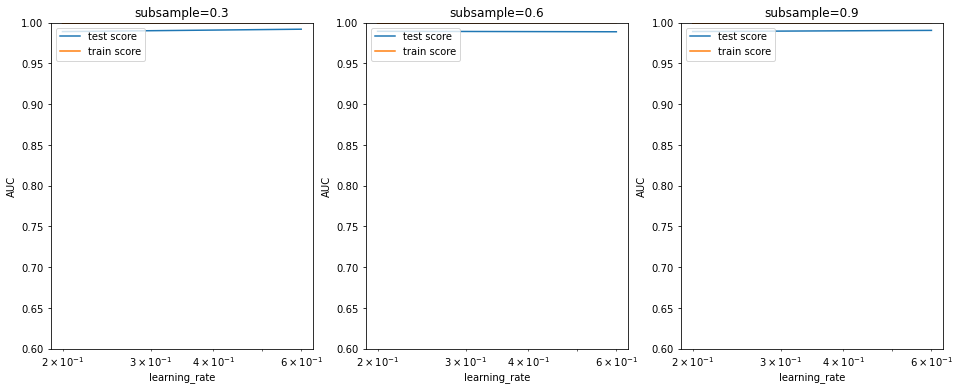

In [35]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [36]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.3}

In [37]:
# chosen hyperparameters

params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.3,
         'objective':'binary:logistic'}

# fit model on training data
xgb_bal_adasyn_model = XGBClassifier(params = params)
xgb_bal_adasyn_model.fit(X_train_adasyn, y_train_adasyn)

[19:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1,
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.3},
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [38]:
# Predictions on the train set
y_train_pred = xgb_bal_adasyn_model.predict(X_train_adasyn)

In [39]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_adasyn, y_train_adasyn)
print(confusion)

[[227449      0]
 [     0 227448]]


In [40]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [41]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_adasyn, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9999956034003302
Sensitivity:- 1.0
Specificity:- 1.0


In [42]:
# classification_report
print(classification_report(y_train_adasyn, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227449
           1       1.00      1.00      1.00    227448

    accuracy                           1.00    454897
   macro avg       1.00      1.00      1.00    454897
weighted avg       1.00      1.00      1.00    454897



In [43]:
# Predicted probability
y_train_pred_proba = xgb_bal_adasyn_model.predict_proba(X_train_adasyn)[:,1]

In [44]:
# roc_auc
auc = metrics.roc_auc_score(y_train_adasyn, y_train_pred_proba)
auc

1.0

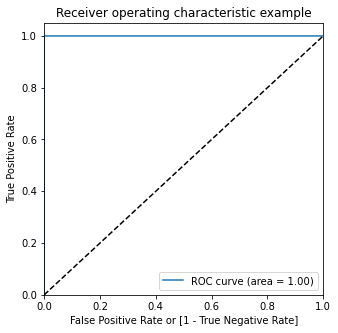

In [45]:
# Plot the ROC curve
draw_roc(y_train_adasyn, y_train_pred_proba)

In [46]:
# Predictions on the test set
y_test_pred = xgb_bal_adasyn_model.predict(X_test)

In [47]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[56825    41]
 [   21    75]]


In [48]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [49]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9989115550718023
Sensitivity:- 0.78125
Specificity:- 0.9992790067878873


In [50]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.65      0.78      0.71        96

    accuracy                           1.00     56962
   macro avg       0.82      0.89      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [51]:
# Predicted probability
y_test_pred_proba = xgb_bal_adasyn_model.predict_proba(X_test)[:,1]

In [52]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9599176499724499

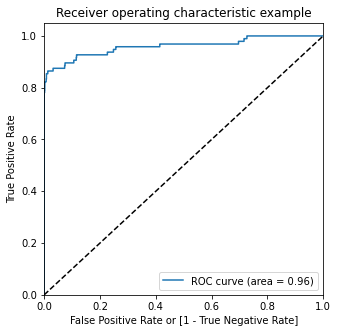

In [53]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [54]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [55]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_adasyn,y_train_adasyn)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [56]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,14.990181,0.124712,0.123053,0.002209,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.902958,0.920355,0.908615,0.910643,0.007246,7
1,14.755897,0.036321,0.120635,0.005588,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.902958,0.920355,0.908615,0.910643,0.007246,7
2,14.655639,0.044641,0.117016,0.002459,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.902958,0.920310,0.911441,0.911570,0.007085,5
3,14.757347,0.094173,0.125849,0.008341,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.902958,0.920310,0.911441,0.911570,0.007085,5
4,26.140200,0.506501,0.120424,0.004168,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.933843,0.947052,0.936044,0.938980,0.005778,4
5,26.278693,0.466305,0.120502,0.005910,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.933865,0.946391,0.938284,0.939513,0.005187,3
6,25.971606,0.322777,0.117568,0.003942,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.938740,0.946164,0.938990,0.941298,0.003442,2
7,26.163999,0.393879,0.127199,0.005643,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.938906,0.945809,0.940590,0.941768,0.002938,1


In [57]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9417684228761273
DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                       min_samples_split=100)


In [58]:
# Model with optimal hyperparameters
dt_bal_adasyn_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)

dt_bal_adasyn_model.fit(X_train_adasyn, y_train_adasyn)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, min_samples_split=50,
                       random_state=100)

In [59]:
# Predictions on the train set
y_train_pred = dt_bal_adasyn_model.predict(X_train_adasyn)

In [60]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_adasyn, y_train_pred)
print(confusion)

[[215929  11520]
 [  1118 226330]]


In [61]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [62]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_adasyn, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9722178866864367
Sensitivity:- 0.9950845907636031
Specificity:- 0.9493512831447929


In [63]:
# classification_report
print(classification_report(y_train_adasyn, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    227449
           1       0.95      1.00      0.97    227448

    accuracy                           0.97    454897
   macro avg       0.97      0.97      0.97    454897
weighted avg       0.97      0.97      0.97    454897



In [64]:
# Predicted probability
y_train_pred_proba = dt_bal_adasyn_model.predict_proba(X_train_adasyn)[:,1]

In [65]:
# roc_auc
auc = metrics.roc_auc_score(y_train_adasyn, y_train_pred_proba)
auc

0.9917591040224101

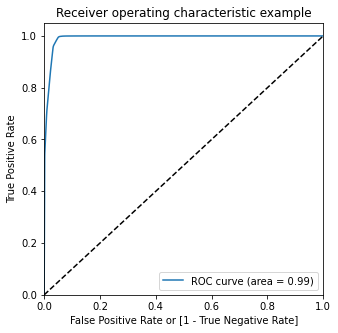

In [66]:
# Plot the ROC curve
draw_roc(y_train_adasyn, y_train_pred_proba)

In [67]:
# Predictions on the test set
y_test_pred = dt_bal_adasyn_model.predict(X_test)

In [68]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[53880  2986]
 [   15    81]]


In [69]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [70]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9473157543625575
Sensitivity:- 0.84375
Specificity:- 0.9474905919178419


In [71]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56866
           1       0.03      0.84      0.05        96

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.95      0.97     56962



In [72]:
# Predicted probability
y_test_pred_proba = dt_bal_adasyn_model.predict_proba(X_test)[:,1]

In [73]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9141440147305362

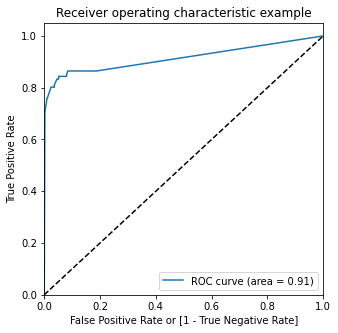

In [74]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
rfc_imb_adasyn_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=100)

In [77]:
# Fit the model
rfc_imb_adasyn_model.fit(X_train_adasyn, y_train_adasyn)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50)

In [78]:
# Predictions on the train set
y_train_pred = rfc_imb_adasyn_model.predict(X_train_adasyn)

In [79]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_adasyn, y_train_adasyn)
print(confusion)

[[227449      0]
 [     0 227448]]


In [80]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [81]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_adasyn, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9371681941186686
Sensitivity:- 1.0
Specificity:- 1.0


In [82]:
# classification_report
print(classification_report(y_train_adasyn, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    227449
           1       0.96      0.92      0.94    227448

    accuracy                           0.94    454897
   macro avg       0.94      0.94      0.94    454897
weighted avg       0.94      0.94      0.94    454897



In [83]:
# Predicted probability
y_train_pred_proba = rfc_imb_adasyn_model.predict_proba(X_train_adasyn)[:,1]

In [84]:
# roc_auc
auc = metrics.roc_auc_score(y_train_adasyn, y_train_pred_proba)
auc

0.9873822816814913

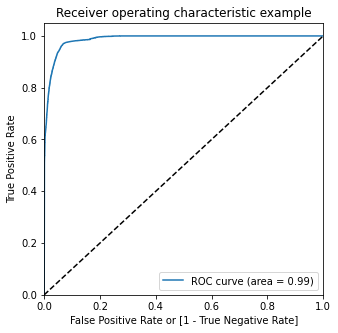

In [85]:
# Plot the ROC curve
draw_roc(y_train_adasyn, y_train_pred_proba)

In [86]:
# Predictions on the test set
y_test_pred = rfc_imb_adasyn_model.predict(X_test)

In [87]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[54367  2499]
 [   12    84]]


In [88]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [89]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9559179804079913
Sensitivity:- 0.875
Specificity:- 0.956054584461717


In [90]:
# classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56866
           1       0.03      0.88      0.06        96

    accuracy                           0.96     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.96      0.98     56962



In [91]:
# Predicted probability
y_test_pred_proba = rfc_imb_adasyn_model.predict_proba(X_test)[:,1]

In [92]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
auc

0.9737045385936529

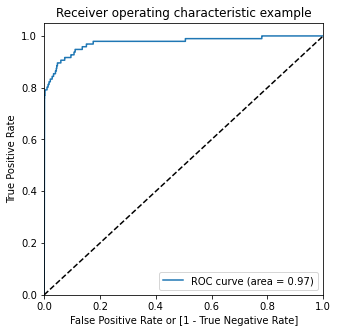

In [93]:
# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [94]:
%store logistic_bal_adasyn_model
%store xgb_bal_adasyn_model
%store dt_bal_adasyn_model
%store rfc_imb_adasyn_model

Stored 'logistic_bal_adasyn_model' (LogisticRegression)
Stored 'xgb_bal_adasyn_model' (XGBClassifier)
Stored 'dt_bal_adasyn_model' (DecisionTreeClassifier)
Stored 'rfc_imb_adasyn_model' (RandomForestClassifier)
